# Descriptive Statistics

Notebook with the descriptive statistics of the graph

In [1]:
# Mathematical and Data Managment
import numpy as np
import pandas as pd
from datetime import datetime

# Graph Managment
import graph_tool.all as gt

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Miscellaneous
from glob import glob
from tqdm import tqdm

/mnt/disk2/anaconda3/envs/gt_global/lib/python3.11/site-packages/graph_tool/draw/cairo_draw.py:1544: RuntimeWarning: Error importing Gtk module: ; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [2]:
def diametros(g: gt.Graph, w = None) -> pd.DataFrame:
    if w==None:
        weights = None
        name = 'Diametro Simple'
    else:
        weights =g.ep[w]
        name = f'Diametro de {w}'
    diametros= []
    for v in g.vertices():
        d = gt.pseudo_diameter(g, source = v, weights = weights)
        diametros.append(d)

    diametros = pd.DataFrame(diametros, columns = [name, 'Edge'])
    return diametros.drop(columns='Edge')

def descriptive(g: gt.Graph, w=None) -> pd.DataFrame:
    # Date
    date = g.ep['Ending date'][g.edges().next()]
    date = datetime.strptime(date, '%Y-%m-%d')
    
    # Edges, Nodes and Dyads
    nodes = g.num_vertices()
    edges = g.num_edges()
    dyads = edges/2
    density = (edges) / (nodes * nodes -1)
    
    # Connected Components 
    SCC, _ = gt.label_components(g, directed=True)
    WCC, _ = gt.label_components(g, directed=False)
    
    N_SCC = len(set(SCC.a))
    N_WCC = len(set(WCC.a))
    
    # Diameter simple
    diametros_df = diametros(g)
    diametro_simple = float(diametros_df.max(axis=0).iloc[0])
        
    results = {
        'Graph Date': date,
        'Nodes': nodes,
        'Edges': edges,
        'Dyads': dyads,
        'Density': density,
        'Strongly Connected Components': N_SCC,
        'Weakly Connected Components': N_WCC,
        'Diametro Simple': diametro_simple
    }
    
    # Diametro con pesos
    if w is not None:
        diametros_w = diametros(g,w)
        diametro = float(diametros_w.max(axis=0).iloc[0])
        tipo_de_diametro = diametro.max(axis=0).index[0]
        
        results[tipo_de_diametro] = diametro
    
    df = pd.DataFrame([results]).set_index('Graph Date')
        
    return df

In [3]:
files_daily = glob('/mnt/disk2/Data/Daily_Graphs/Graphs/*.graphml')
files_3_day = glob('/mnt/disk2/Data/3_Day_Graphs/Graphs/*.graphml')

In [6]:
ls = []
for file in tqdm(files_daily):
    # Get date
    date = file.split('/')[-1].split('.')[0].split('_')[-1]
    date = datetime.strptime(date, '%Y-%m-%d')
    g = gt.load_graph(file)
    
    # Get Node Degrees Average
    for stat in ['in', 'out', 'total']: 
        vertex_average = gt.vertex_average(g, stat)
        row = [vertex_average[0], vertex_average[1], date, f'Average Degree {stat}']
        ls.append(row)
        
    # Get Edge Propety Average
    for stat in dict(g.ep).items():
        try:
            edge_average = gt.edge_average(g, stat[1])
            row = [edge_average[0], edge_average[1], date, stat[0]]
            ls.append(row)
        except:
            pass
    
    # Clustering and transitivity
    cluester_coef = gt.global_clustering(g,weight = g.ep['Normal Weight'])
    row = [cluester_coef[0], cluester_coef[1], date, 'Global Clustering Coefficient']
    ls.append(row)
    
    transitivity = gt.global_clustering(g)
    row = [transitivity[0], transitivity[1], date, 'Transitivity']
    ls.append(row)
    
    # Number of Edges and Nodes, Dyads and Density
    nodes = g.num_vertices()
    isolate = g.vp['Isolate'].a.sum()
    edges = g.num_edges()
    dyads = edges/2
    density = (edges * 2) / (nodes * nodes -1)
    
    ls.append([nodes-isolate, np.nan, date, 'Non isolate Nodes'])
    ls.append([isolate, np.nan, date, 'Isolate Nodes'])
    ls.append([edges, np.nan, date, 'Number of Edges'])
    ls.append([dyads, np.nan, date, 'Number of Dyads'])
    ls.append([density, np.nan, date, 'Number of Density'])
    
    # Connected Components 
    SCC, _ = gt.label_components(g, directed=True)
    WCC, _ = gt.label_components(g, directed=False)
    
    N_SCC = len(set(SCC.a))
    N_WCC = len(set(WCC.a))
    
    ls.append([N_SCC, np.nan, date, 'Strongly Connected Components'])
    ls.append([N_WCC, np.nan, date, 'Weakly Connected Components'])

# Get Visualization
viz_daily = pd.DataFrame(ls, columns=['Value','SE','Date', 'Statistic'])
viz_daily = viz_daily.astype({
    'Value': 'double',
    'SE':'double'
})

# Get Confidence Interval
viz_daily['Lower 5%'] = viz_daily['Value'] - 1.96*viz_daily['SE']
viz_daily['Upper 5%'] = viz_daily['Value'] + 1.96*viz_daily['SE']
viz_daily = viz_daily.set_index('Date')
viz_daily = viz_daily.sort_index()
viz_daily

  0%|          | 0/63 [00:00<?, ?it/s]

100%|██████████| 63/63 [01:16<00:00,  1.21s/it]


,Value,SE,Statistic,Lower 5%,Upper 5%
Date,,,,,
2021-04-28,85767.000000,NaN,Number of Dyads,NaN,NaN
2021-04-28,4.923479,0.063390,Average Degree out,4.799234,5.047723
2021-04-28,9.846958,0.301329,Average Degree total,9.256352,10.437563
2021-04-28,0.117691,0.000467,Normal Weight,0.116776,0.118606
2021-04-28,1.432439,0.003842,Number of rts,1.424909,1.439969
...,...,...,...,...,...
2021-06-29,17575.000000,NaN,Isolate Nodes,NaN,NaN
2021-06-29,85551.000000,NaN,Number of Edges,NaN,NaN
2021-06-29,42775.500000,NaN,Number of Dyads,NaN,NaN


In [7]:
viz_daily.loc['2021-06-02']

,Value,SE,Statistic,Lower 5%,Upper 5%
Date,,,,,
2021-06-02,3.543772,0.236537,Average Degree in,3.080159,4.007384
2021-06-02,3.543772,0.047542,Average Degree out,3.450589,3.636954
2021-06-02,7.087543,0.243047,Average Degree total,6.611172,7.563914
2021-06-02,15490.000000,NaN,Weakly Connected Components,NaN,NaN
2021-06-02,32993.000000,NaN,Strongly Connected Components,NaN,NaN
2021-06-02,0.000203,NaN,Number of Density,NaN,NaN
2021-06-02,123465.000000,NaN,Number of Edges,NaN,NaN
2021-06-02,15309.000000,NaN,Isolate Nodes,NaN,NaN
2021-06-02,61732.500000,NaN,Number of Dyads,NaN,NaN


In [8]:
plt.rcParams['font.family'] = 'cmr10'
plt.rcParams['mathtext.fontset'] = 'cm'

/tmp/ipykernel_2697371/814927529.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(12, 5))


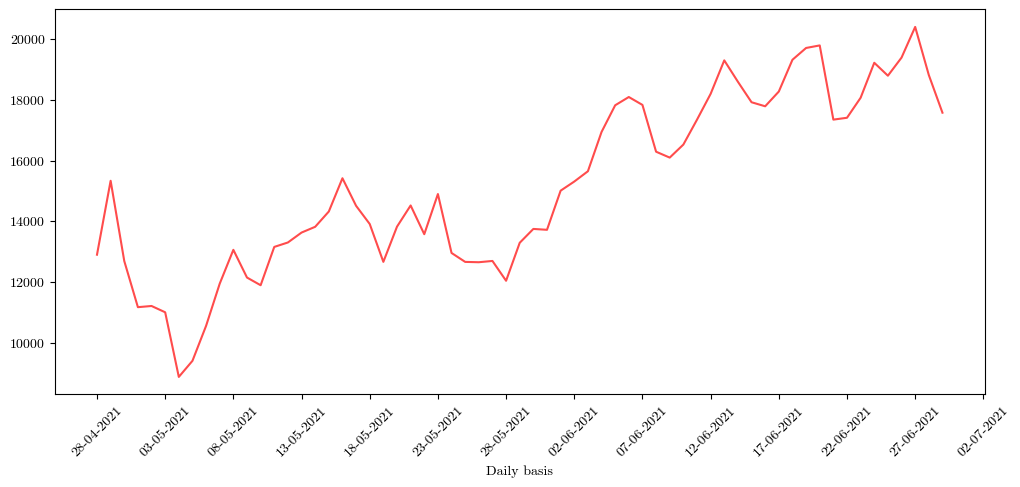

In [9]:
# Isolated Nodes
isolate = viz_daily[viz_daily['Statistic'] == 'Isolate Nodes']
fig, ax = plt.subplots(figsize=(12, 5))

# In Graph
sns.lineplot(data=isolate, x=isolate.index, y='Value', color='red', ax=ax, label='_no_legend', alpha = 0.7)

ax.set_xlabel('Daily basis')
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

fig.savefig("../Results/Presentacion Trees/Isolated_nodes_daily.png", dpi=300, bbox_inches='tight')

/tmp/ipykernel_2697371/3626024747.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(12, 5))


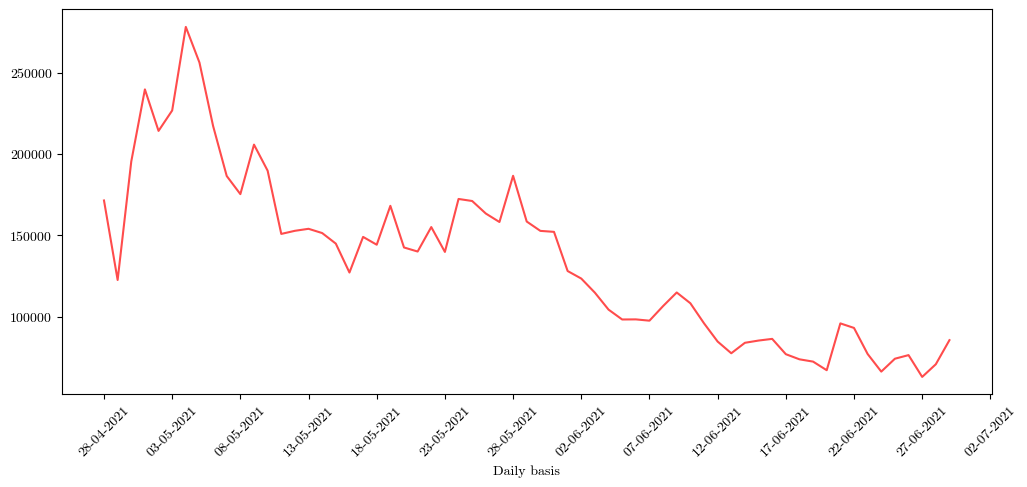

In [10]:
# Number of Edges
edges_df = viz_daily[viz_daily['Statistic'] == 'Number of Edges']
fig, ax = plt.subplots(figsize=(12, 5))

# In Graph
sns.lineplot(data=edges_df, x=edges_df.index, y='Value', color='red', ax=ax, label='_no_legend', alpha = 0.7)

ax.set_xlabel('Daily basis')
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

fig.savefig("../Results/Presentacion Trees/number_of_edges_daily.png", dpi=300, bbox_inches='tight')

/tmp/ipykernel_2697371/255552833.py:6: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(12,5))


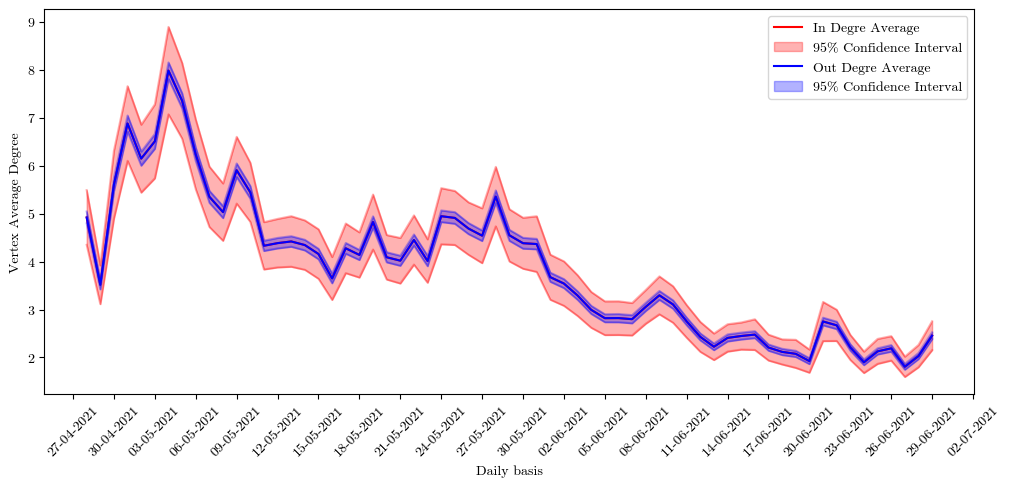

In [11]:
# Separate Types
in_deg = viz_daily[viz_daily['Statistic'] == 'Average Degree in']
out_deg = viz_daily[viz_daily['Statistic'] == 'Average Degree out']

# GRAAAAAPH
fig, ax = plt.subplots(figsize=(12,5))

# In Graph
sns.lineplot(data=in_deg, x=in_deg.index, y='Value', color='red', ax=ax, label='In Degre Average')
sns.lineplot(data=in_deg, x=in_deg.index, y='Lower 5%', color='red', ax=ax, alpha=0.3, label='_nolegend_')
sns.lineplot(data=in_deg, x=in_deg.index, y='Upper 5%', color='red', ax=ax, alpha=0.3, label='_nolegend_')

plt.fill_between(in_deg.index, in_deg['Lower 5%'], in_deg['Upper 5%'], color='red', alpha=0.3, label='95% Confidence Interval')

# Out Graph
sns.lineplot(data=out_deg, x=out_deg.index, y='Value', color='blue', ax=ax, label='Out Degre Average')
sns.lineplot(data=out_deg, x=out_deg.index, y='Lower 5%', color='blue', ax=ax, alpha=0.3, label='_nolegend_')
sns.lineplot(data=out_deg, x=out_deg.index, y='Upper 5%', color='blue', ax=ax, alpha=0.3, label='_nolegend_')

plt.fill_between(out_deg.index, out_deg['Lower 5%'], out_deg['Upper 5%'], color='blue', alpha=0.3, label='95% Confidence Interval')

# Labels
ax.set_xlabel('Daily basis')
ax.set_ylabel('Vertex Average Degree')
ax.tick_params(axis = 'x',rotation=45)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.legend(bbox_to_anchor=(1, 1), loc='best')
fig.savefig("../Results/Presentacion Trees/average_degree_daily.png", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_2697371/877231321.py:5: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(12, 5))


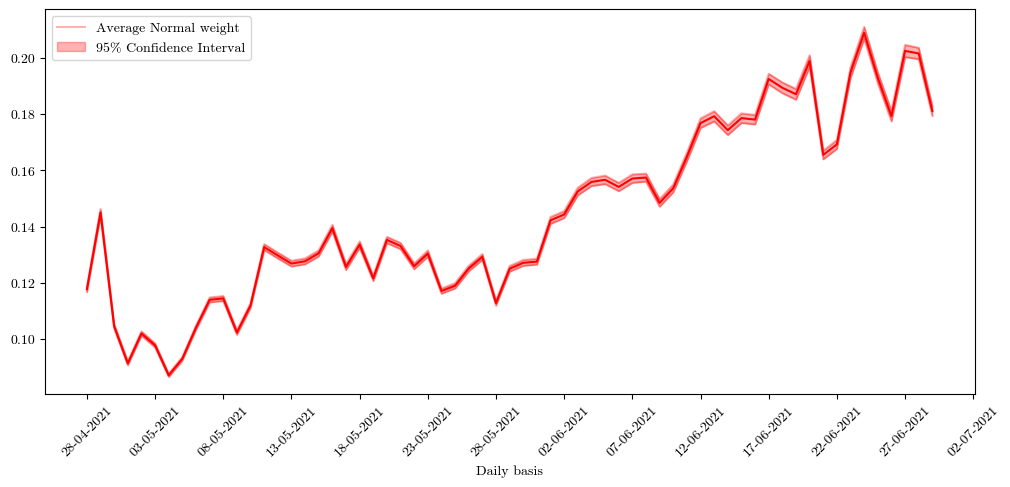

In [12]:
# Separate Types
normal = viz_daily[viz_daily['Statistic'] == 'Normal Weight']

# GRAAAAAPH
fig, ax = plt.subplots(figsize=(12, 5))

# In Graph
sns.lineplot(data=normal, x=normal.index, y='Value', color='red', ax=ax, label='_nolegend')
sns.lineplot(data=normal, x=normal.index, y='Lower 5%', color='red', ax=ax, alpha=0.3, label='Average Normal weight')
sns.lineplot(data=normal, x=normal.index, y='Upper 5%', color='red', ax=ax, alpha=0.3, label='_nolegend_')

ax.fill_between(normal.index, normal['Lower 5%'], normal['Upper 5%'], color='red', alpha=0.3, label='95% Confidence Interval')
ax.set_xlabel('Daily basis')
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('')
ax.legend()

ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

fig.savefig("../Results/Presentacion Trees/average_normal_weight_daily.png", dpi=300, bbox_inches='tight')

/tmp/ipykernel_2697371/3102067319.py:6: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,2,figsize=(12, 5))


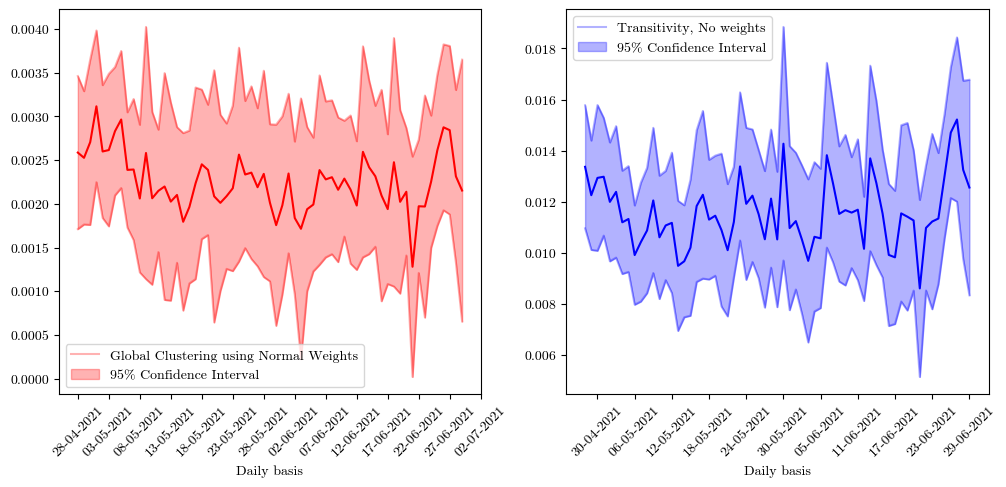

In [13]:
# Separate Types
clust = viz_daily[viz_daily['Statistic'] == 'Global Clustering Coefficient']
transit = viz_daily[viz_daily['Statistic'] == 'Transitivity']

# GRAAAAAPH
fig, ax = plt.subplots(1,2,figsize=(12, 5))

# In Graph
sns.lineplot(data=clust, x=clust.index, y='Value', color='red', ax=ax[0], label='_nolegend')
sns.lineplot(data=clust, x=clust.index, y='Lower 5%', color='red', ax=ax[0], alpha=0.3, label='Global Clustering using Normal Weights')
sns.lineplot(data=clust, x=clust.index, y='Upper 5%', color='red', ax=ax[0], alpha=0.3, label='_nolegend_')

ax[0].fill_between(clust.index, clust['Lower 5%'], clust['Upper 5%'], color='red', alpha=0.3, label='95% Confidence Interval')
ax[0].set_xlabel('Daily basis')
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_ylabel('')
ax[0].legend()

ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# Out Graph
sns.lineplot(data=transit, x=transit.index, y='Value', color='blue', ax=ax[1], label='_nolegend_')
sns.lineplot(data=transit, x=transit.index, y='Lower 5%', color='blue', ax=ax[1], alpha=0.3, label='Transitivity, No weights')
sns.lineplot(data=transit, x=transit.index, y='Upper 5%', color='blue', ax=ax[1], alpha=0.3, label='_nolegend_')

ax[1].fill_between(transit.index, transit['Lower 5%'], transit['Upper 5%'], color='blue', alpha=0.3, label='95% Confidence Interval')

ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=6))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax[1].set_xlabel('Daily basis')
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_ylabel('')
ax[1].legend()

fig.savefig("../Results/Presentacion Trees/transitivity_and_global_clustering_daily.png", dpi=300, bbox_inches='tight')

/tmp/ipykernel_2697371/218905541.py:6: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(1,2,figsize=(12, 5))


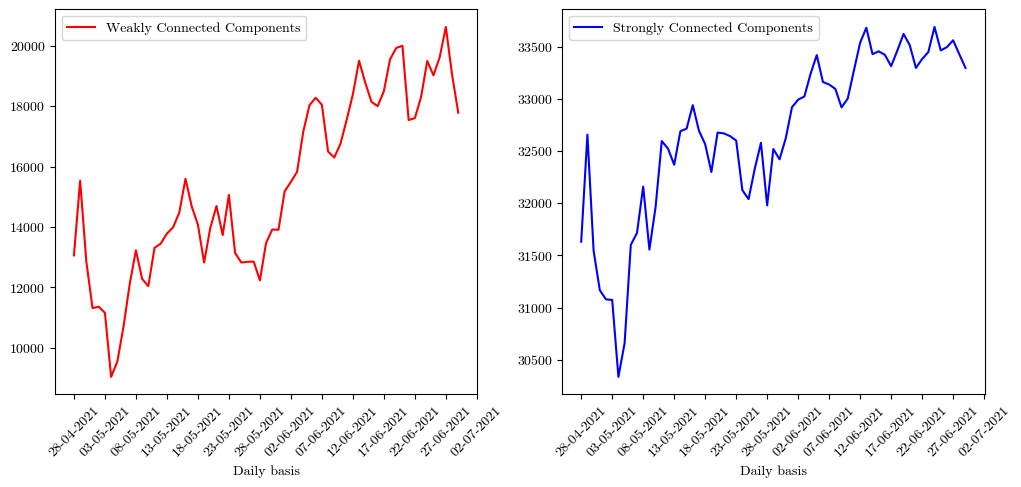

In [14]:
# Separate Types
wcc_df = viz_daily[viz_daily['Statistic'] == 'Weakly Connected Components']
scc_df = viz_daily[viz_daily['Statistic'] == 'Strongly Connected Components']

# GRAAAAAPH
fig, axes = plt.subplots(1,2,figsize=(12, 5))

# In Graph
sns.lineplot(data=wcc_df, x=wcc_df.index, y='Value', color='red', ax=axes[0], label='Weakly Connected Components')
sns.lineplot(data=scc_df, x=scc_df.index, y='Value', color='blue', ax=axes[1], label='Strongly Connected Components')

for ax in axes:
    ax.set_xlabel('Daily basis')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel('')

    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

ax.legend()
fig.savefig("../Results/Presentacion Trees/strongly_and_weakly_connected_components_daily.png", dpi=300, bbox_inches='tight')

In [15]:
viz_daily.loc['2021-04-28']

,Value,SE,Statistic,Lower 5%,Upper 5%
Date,,,,,
2021-04-28,85767.000000,NaN,Number of Dyads,NaN,NaN
2021-04-28,4.923479,0.063390,Average Degree out,4.799234,5.047723
2021-04-28,9.846958,0.301329,Average Degree total,9.256352,10.437563
2021-04-28,0.117691,0.000467,Normal Weight,0.116776,0.118606
2021-04-28,1.432439,0.003842,Number of rts,1.424909,1.439969
2021-04-28,0.002586,0.000446,Global Clustering Coefficient,0.001711,0.003460
2021-04-28,0.013372,0.001228,Transitivity,0.010965,0.015779
2021-04-28,4.923479,0.291581,Average Degree in,4.351980,5.494977
2021-04-28,21938.000000,NaN,Non isolate Nodes,NaN,NaN


In [16]:
viz_daily['Statistic'].unique()

array(['Number of Dyads', 'Average Degree out', 'Average Degree total',
       'Normal Weight', 'Number of rts', 'Global Clustering Coefficient',
       'Transitivity', 'Average Degree in', 'Non isolate Nodes',
       'Number of Edges', 'Number of Density',
       'Strongly Connected Components', 'Weakly Connected Components',
       'Isolate Nodes'], dtype=object)

/tmp/ipykernel_2697371/2490110545.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(12, 5))


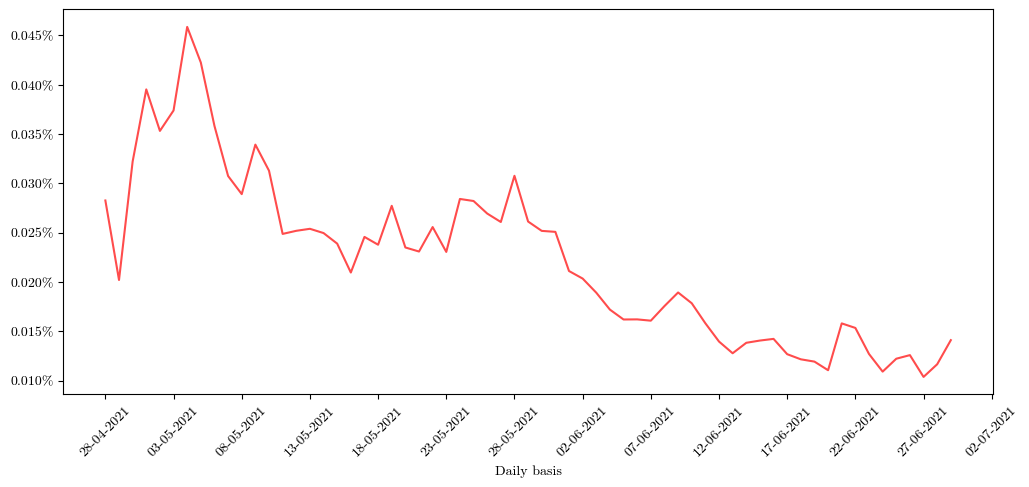

In [17]:
# Number of Edges
den = viz_daily[viz_daily['Statistic'] == 'Number of Density']
fig, ax = plt.subplots(figsize=(12, 5))
percentage_formatter = FuncFormatter(lambda x, pos: f'{x*100:.3f}%')
# In Graph
sns.lineplot(data=den, x=den.index, y='Value', color='red', ax=ax, label='_no_legend', alpha = 0.7)

ax.set_xlabel('Daily basis')
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

fig.savefig("../Results/Presentacion Trees/density_daily.png", dpi=300, bbox_inches='tight')

## Daily retweet network (with no rolling window)

In [18]:
files = glob('/mnt/disk2/Data/Daily_graphs/*.graphml')
files.sort()

- **Average Degree:** is simply the average number of edges per node in the graph.
$$Average Degree = \frac{Total Edges}{Total Nodes}=\frac{m}{n}$$

In [4]:
descriptive_statistics = dict()

for file in tqdm(files_daily):
    # Get date
    date = file.split('/')[-1].split('.')[0]
    g = gt.load_graph(file)

    # Extract degrees (# PREGUNTAR ESTA INTERPRETACIÓN)

    # Number of links per node
    total_degree = g.degree_property_map("total").a
    total_degree = np.array(total_degree)

    # Number of retweets made by -i from i
    in_degree = g.degree_property_map("in").a
    in_degree = np.array(in_degree)

    # Number of retweets made by i from -i
    out_degree = g.degree_property_map("out").a
    out_degree = np.array(out_degree)

    # Number of edges
    n_edges = g.num_edges()

    # Nomber of nodes
    n_nodes = g.num_vertices()

    # Get Assortativity
    assortativity = gt.assortativity(g, deg = g.vp['Label'])

    descriptive_statistics[date] = {
        "n_nodes": n_nodes,
        "n_edges": n_edges,
        "total_degree": total_degree,
        "in_degree": in_degree,
        "out_degree": out_degree,
        "assortativity_mean": assortativity[0],
        "assortativity_variance": assortativity[1]
    }

  0%|          | 0/63 [00:00<?, ?it/s]

: 

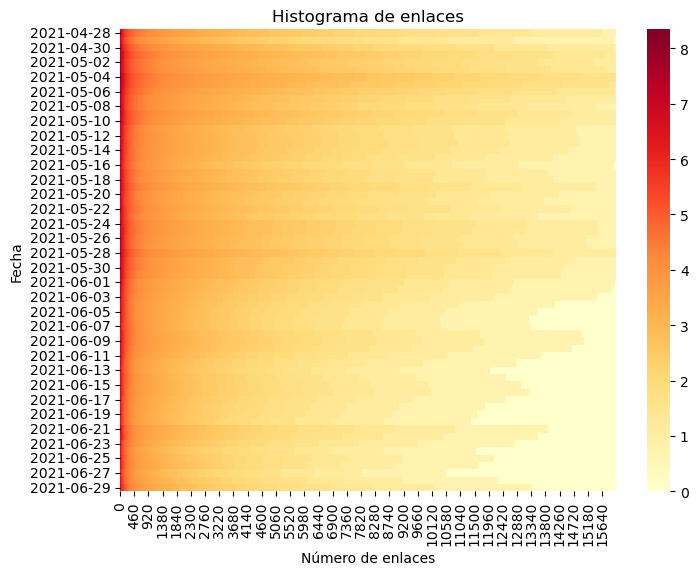

In [43]:
min_n_nodes = min([descriptive_statistics[d]["n_nodes"] for d in descriptive_statistics.keys()])

# Ordenamos de mayor cantidad de enlaces a menor y creamos un vector para extraer a los min_n_nodes usuarios con mas enlaces.
# Luego vamos a crear un dataframe con la historia de como evoluciona la cantidad de enlaces en el tiempo
history_total_degree = pd.concat([pd.DataFrame(np.sort(descriptive_statistics[d]["total_degree"])[::-1][0:min_n_nodes]).T for d in descriptive_statistics.keys()])
history_total_degree.index = [i for i in descriptive_statistics.keys()]

fig, ax = plt.subplots(figsize = (8, 6))
plt.title("Histograma de enlaces")
sns.heatmap(np.log(history_total_degree), ax = ax, cmap = "YlOrRd")
plt.xlabel("Número de enlaces");
plt.ylabel("Fecha");

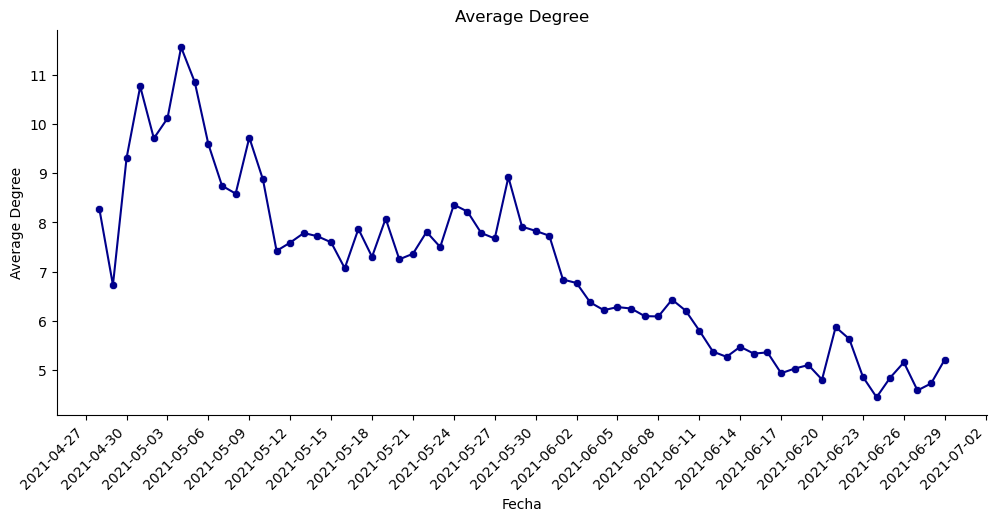

In [123]:
import matplotlib.dates as mdates
av_degree = pd.concat([pd.DataFrame({"Fecha": d, "Average Degree": descriptive_statistics[d]["n_edges"]/descriptive_statistics[d]["n_nodes"]}, index = [0]) for d in descriptive_statistics.keys()])
av_degree["Fecha"] = pd.to_datetime(av_degree["Fecha"])

fig, ax = plt.subplots(figsize = (12, 5))
sns.despine()
plt.title("Average Degree")
sns.lineplot(data = av_degree, x = "Fecha", y = "Average Degree", ax = ax, color = "darkblue")
sns.scatterplot(data = av_degree, x = "Fecha", y = "Average Degree", ax = ax, color = "darkblue")
plt.xlabel("Fecha");
plt.xticks(rotation = 45, ha = 'right');
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))

- **Assortativity:** is a preference for a network's nodes to attach to others that are similar in some way. Though the specific measure of similarity may vary, network theorists often examine assortativity in terms of a node's degree.

    The **assortativity coefficient** is the Pearson correlation coefficient of degree between pairs of linked nodes. Positive values of `r` indicate a correlation between nodes of similar degree, while negative values indicate relationships between nodes of different degree. In general, `r` lies between `−1` and `1`. When `r = 1`, the network is said to have perfect assortative mixing patterns, when `r = 0` the network is non-assortative, while at `r = −1` the network is completely disassortative.

    The *assortativity coefficient* is given by 

    $$
    r = \frac{\sum_{jk}{jk (e_{jk} - q_j q_k)}}{\sigma_{q}^{2}}
    $$

    In this equation:

    - $ \sum_{jk} $ denotes the summation over all degrees $ j $ and $ k $ in the network.
    - $ jk $ represents the product of degrees $ j $ and $ k $.
    - $ e_{jk} $ is the joint probability distribution of the remaining degrees of two connected vertices. In an undirected graph, this is symmetric and must satisfy the sum rules:
        - $ \sum_{jk}{e_{jk}} = 1 $, ensuring that the total probability is 1.
        - $ \sum_{j}{e_{jk}} = q_{k} $, linking it to the distribution of the remaining degree.
    - $ q_j $ and $ q_k $ are the distributions of the remaining degree for vertices of degrees $ j $ and $ k $, respectively. 
    - $ \sigma_{q}^{2} $ is the variance of the distribution of the remaining degree.

    The term $ q_{k} $ represents the distribution of the *remaining degree*, which captures the number of edges leaving a node, excluding the edge that connects the pair in question. This distribution is derived from the degree distribution $ p_{k} $ as follows:

    $$
    q_{k} = \frac{(k+1)p_{k+1}}{\sum_{j \geq 1} j p_j}
    $$

    - Here, $ p_{k} $ is the degree distribution of the network, and $ p_{k+1} $ refers to the probability of a node having $ k+1 $ connections.


- **Categorical Assortativity (assortativity by attribute):** is a measure used to determine how often nodes with a certain categorical attribute, like color or type, connect to other nodes with the same attribute. It is given by:

    $$
    r = \frac{\sum_{ij}{e_{ij} - q_i q_j}}{\sum_{i}{q_i q_i} - \sum_{i}{q_i q_j}}
    $$

    Where:

    - $ e_{ij} $ is the proportion of edges in the network that connect nodes of type $ i $ to nodes of type $ j $.
    - $ q_i $ and $ q_j $ are the proportions of each type of node (type $ i $ and $ j $, respectively) at the ends of a randomly chosen edge.

    In this context:

    - A positive value of $ r $ indicates assortative mixing, where nodes tend to connect to others that are similar.
    - A negative value of $ r $ indicates disassortative mixing, where nodes tend to connect to others that are different.
    - A value of $ r $ close to 0 suggests no particular preference for nodes to connect to others based on the categorical attribute.

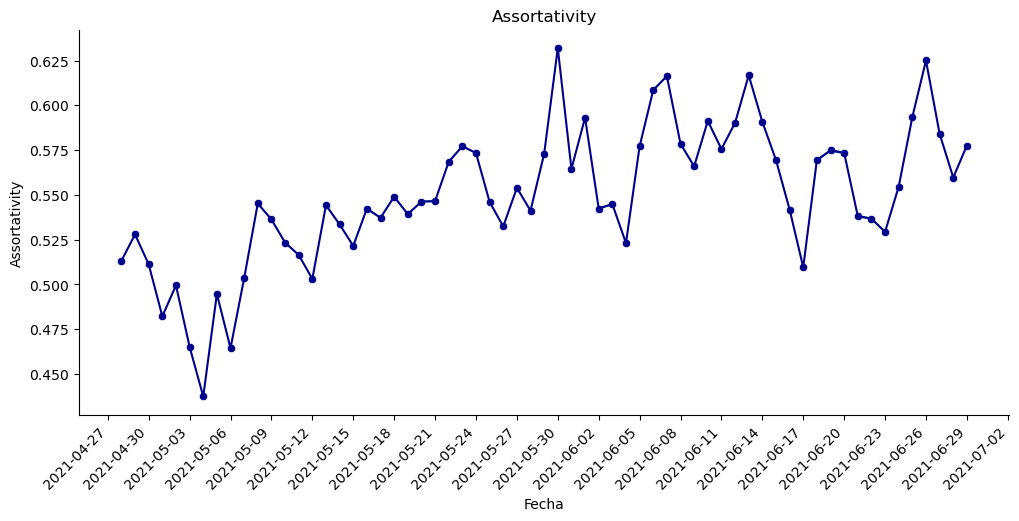

In [124]:
assortativity = pd.concat([pd.DataFrame({"Fecha": d, "assortativity_mean": descriptive_statistics[d]["assortativity_mean"], "assortativity_variance": descriptive_statistics[d]["assortativity_variance"], "N": descriptive_statistics[d]["n_nodes"]}, index = [0]) for d in descriptive_statistics.keys()])
assortativity["Fecha"] = pd.to_datetime(assortativity["Fecha"])
assortativity["assortativity_low"] = assortativity["assortativity_mean"] - 1.96*np.sqrt(assortativity["assortativity_variance"])/np.sqrt(assortativity["N"])
assortativity["assortativity_high"] = assortativity["assortativity_mean"] + 1.96*np.sqrt(assortativity["assortativity_variance"])/np.sqrt(assortativity["N"])

fig, ax = plt.subplots(figsize = (12, 5))
sns.despine()
plt.title("Assortativity")
sns.lineplot(data = assortativity, x = "Fecha", y = "assortativity_mean", ax = ax, color = "darkblue")
sns.scatterplot(data = assortativity, x = "Fecha", y = "assortativity_mean", ax = ax, color = "darkblue")
# El IC es MUY pequeño porque N es MUY grande
ax.fill_between(assortativity["Fecha"], assortativity["assortativity_low"], assortativity["assortativity_high"])
plt.xlabel("Fecha");
plt.ylabel("Assortativity")
plt.xticks(rotation = 45, ha = 'right');
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))

- **Betweenness centrality:** is a measure of centrality in a graph based on shortest paths. For every pair of vertices in a connected graph, there exists at least one shortest path between the vertices such that either the number of edges that the path passes through (for unweighted graphs) or the sum of the weights of the edges (for weighted graphs) is minimized. The betweenness centrality for each vertex is the number of these shortest paths that pass through the vertex.

- 

In [4]:
ls = []
for file in tqdm(files_daily):
    # Get date
    g = gt.load_graph(file)
    date = g.gp['Date']
    
    # Check for edge weight property
    if "weight" in g.edge_properties:
        weight_prop = g.ep["weight"]
    else:
        weight_prop = None

    # Centrality measures
    vertex_betweenness, edge_betweenness = gt.betweenness(g, weight=weight_prop)
    ls.append([float(np.mean(edge_betweenness.a)), float(np.std(edge_betweenness.a)), date, 'Edge Betweenness'])

    pagerank_scores = gt.pagerank(g, weight=weight_prop)
    ls.append([float(np.mean(pagerank_scores.a)), float(np.std(pagerank_scores.a)), date, 'PageRank'])

    eigenvector_values, eigenvector = gt.eigenvector(g, weight=weight_prop)
    ls.append([float(np.mean(eigenvector.a)), float(np.std(eigenvector.a)), date, 'Eigenvector Centrality'])

# Create DataFrame
viz = pd.DataFrame(ls, columns = ['Value', 'Standard Deviation', 'Date', 'Statistic'])

# Convert to numeric where applicable
viz['Value'] = pd.to_numeric(viz['Value'], errors='coerce')
viz['Standard Deviation'] = pd.to_numeric(viz['Standard Deviation'], errors='coerce')

viz.head()

100%|██████████| 63/63 [02:36<00:00,  2.48s/it]


,Value,Standard Deviation,Date,Statistic
0,0.000002,0.000029,2021-06-07,Edge Betweenness
1,0.000027,0.000328,2021-06-07,PageRank
2,0.000370,0.005188,2021-06-07,Eigenvector Centrality
3,0.000002,0.000024,2021-05-01,Edge Betweenness
4,0.000027,0.000231,2021-05-01,PageRank


In [7]:
viz

,Value,Standard Deviation,Date,Statistic
0,0.000002,0.000029,2021-06-07,Edge Betweenness
1,0.000027,0.000328,2021-06-07,PageRank
2,0.000370,0.005188,2021-06-07,Eigenvector Centrality
3,0.000002,0.000024,2021-05-01,Edge Betweenness
4,0.000027,0.000231,2021-05-01,PageRank
...,...,...,...,...
184,0.000027,0.000176,2021-06-04,PageRank
185,0.000344,0.005190,2021-06-04,Eigenvector Centrality
186,0.000002,0.000032,2021-06-11,Edge Betweenness
187,0.000027,0.000260,2021-06-11,PageRank


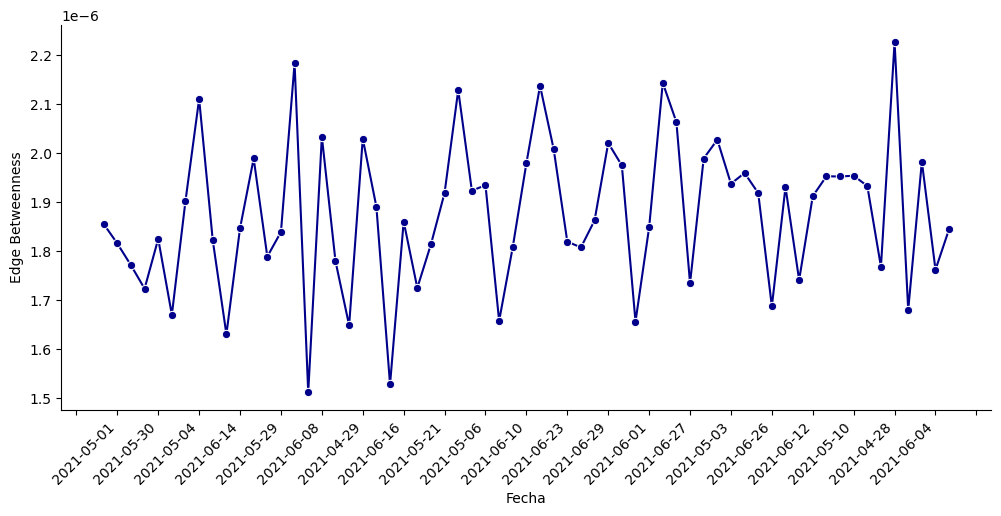

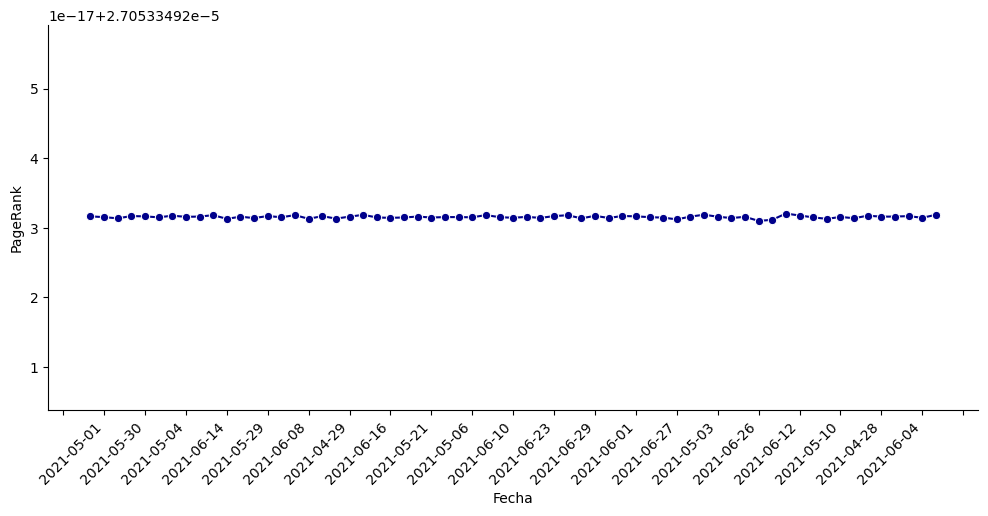

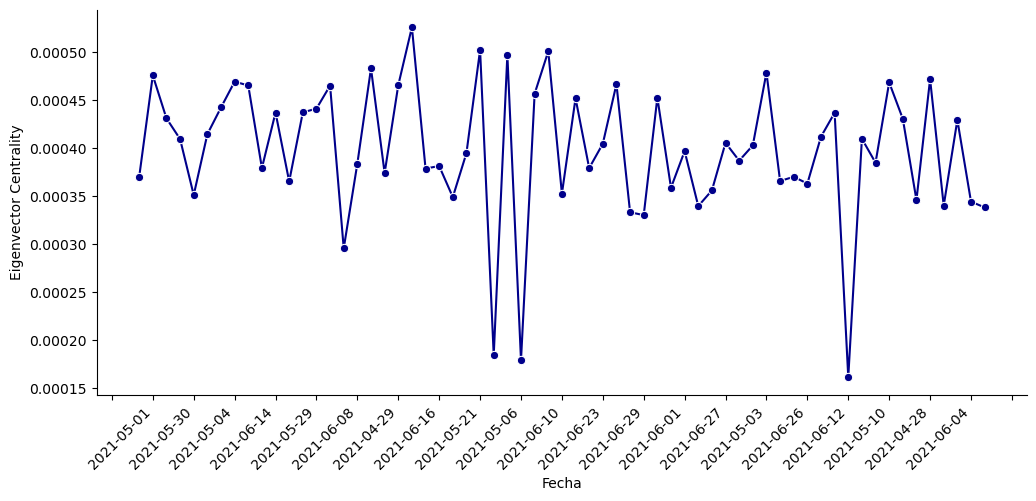

In [9]:
for i in viz["Statistic"].unique():
    fig, ax = plt.subplots(figsize = (12, 5))
    sns.despine()
    sns.lineplot(data = viz.query(f"Statistic == '{i}'"), x = "Date", y = "Value", ax = ax, marker = 'o', color = "darkblue")
    plt.ylabel(i)
    plt.xlabel("Fecha")
    plt.xticks(rotation = 45, ha = 'right');
    ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
    fig.savefig(f"../Results/Presentacion Trees/Descriptive statistics/{i}_daily.png", dpi=300, bbox_inches='tight')